In [1]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Build Model


In [63]:
class DQN:
    def __init__(self,
                 InputShape = 3,
                 NActions = 40,
                 Gamma = 1,
                 MemorySize = 10000,
                 MinMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 1,
                 Dense_no = 64,
                 BatchSize = 32,
                 Epsilon = 0.1,
                 Epsilon_Decay = 0.99,
                 learning_rate = 0.001):
        
        # Preset. #
        self.InputShape = InputShape

        # Hyperparameters. # (Tuneable)
        self.NActions = NActions # Number of Discretized Actions.
        self.Gamma = Gamma # Discount Factor
        self.MemorySize = MemorySize # Max Memory Size
        self.MinMemory = MinMemory # Min Memory Size before Training.
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes # Frequency of Target Update.
        self.Dense_no = Dense_no # Dense Layers
        self.BatchSize = BatchSize # Batch Size for Training.
        self.Optimiser = Adam(learning_rate=learning_rate) # Optimiser for Training.
        self.Epsilon = Epsilon # Exploration Rate.
        self.Epsilon_Decay = Epsilon_Decay # Exploration Decay Rate.
        
        # Main Model. #
        self.Main = self.Model('Main')
        
        # Target Model. #
        self.T = self.Model('Target')
        self.update_t_weights()
        self.Memory = deque(maxlen = MemorySize)
        self.TargetUpdateCounter = 0
    
    # Create Model. #
    def Model(self, Type):

        inputs = Input(shape = (self.InputShape), name = 'Input')
        x = Dense(self.Dense_no, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.Dense_no, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateMemory(self, Information): # Update Memory.
        self.Memory.append(Information)

    def update_t_weights(self): # Update Target Model.
        self.T.set_weights(self.Main.get_weights())

    def PendulumActionConverter(self, A): # Discritize Action.
        ActualTorque = (A / self.NActions - 0.5) * 4 # Normalise to [-2, 2] 
        return ActualTorque

    def PendulumInverseActionConverter(self, A): # Undiscritize Action.
        ActualA = round((A + 2) * (self.NActions - 1) / 4)
        return(ActualA)
    
    def EpsilonDecay(self): # Decay Epsilon.
        self.Epsilon = self.Epsilon * self.Epsilon_Decay
        
    def GetAction(self, env, Q): # Getting Action from Q Values.
        if np.random.rand() <= self.Epsilon:
            AStep = env.action_space.sample()
            A = self.PendulumInverseActionConverter(AStep[0])
        else:
            A = np.argmax(Q)
            A = self.PendulumActionConverter(A)
            AStep = np.array([A])
            A = self.PendulumInverseActionConverter(A)
        return A, AStep

    def Train(self, EndOfEpisode, Normalization): # Training.
        if len(self.Memory) < self.MinMemory:
            return

        TrainingData = random.sample(self.Memory, self.BatchSize)
        
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS)) # Q Values for Current State.
        
        if Normalization == True:
            all_rewards = [experience[2] for experience in self.Memory]
            mean_reward = np.mean(all_rewards)
            std_reward = np.std(all_rewards)
            normalized_rewards = [(experience[2] - mean_reward) / std_reward for experience in TrainingData]


        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.T(ListOfSNext) # Q Values for Next State.
        

        X = []
        Y = []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData): 
            if not Done:
                MaxQNext = np.max(ListOfQNext[index]) # Target Q Value for Next State.
                QNext = R + self.Gamma * MaxQNext # Sum of the reward and the discounted maximum Q-value

                if Normalization == True:
                    QNext = normalized_rewards[index] + self.Gamma * MaxQNext      
            else:
                QNext = R # If the episode is done, the Q-value is just the reward.
                if Normalization == True:
                    QNext = normalized_rewards[index]
            Q = ListOfQ[index] 
            Q[A] = QNext  # Q-value for the chosen action (A) in the current state is updated to the target 

            X.append(S) # States
            Y.append(Q) # Q Values
        self.GTfit(X, Y)
                
        if EndOfEpisode:
            self.TargetUpdateCounter += 1

        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.update_t_weights()
            self.TargetUpdateCounter = 0
        
    @tf.function
    def GTfit(self, X, Y): # Gradient Tape Fit.
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))



In [55]:
def OneEpisode(dqn, _, Normalization = False):
    env = gym.make('Pendulum-v0')
    S = env.reset()
    score = 0
    Done = False
    while not Done:
        Q = dqn.Main(S.reshape(-1, S.shape[0]))
        A, AStep = dqn.GetAction(env, Q)
        if not _ % 10 and len(dqn.Memory) >= dqn.MinMemory:
            env.render()
        SNext, R, Done, Info = env.step(AStep)
        dqn.UpdateMemory((S, A, R, SNext, Done))
        dqn.Train(Done, Normalization)
        score += R
        if Done:
            dqn.EpsilonDecay()
            env.close()
            return score
        S = SNext

def RunEpisodes(dqn, episodes, Normalize = False):
    import time
    STARTTIME = time.time()
    score = []
    ma = []
    for _ in range(episodes):
        s = OneEpisode(dqn, _, Normalize)
        score.append(s)
        moving_average = np.mean(score[-100:])
        ma.append(moving_average)
        # if len(score) >= 5 and all(r > -500 for r in score[-5:]):
        #     dqn.Epsilon = 0
        print(f'Episode {_}, Score : {s}, Moving Average : {moving_average}, Epsilon : {dqn.Epsilon}')
        
    print(f'Total time taken: {time.time() - STARTTIME} seconds ...')
    return score, ma

## Base Model

In [16]:
EPISODES = 150  
episode_number = np.arange(EPISODES)
dqn = DQN(InputShape = 3, NActions = 40)
base_scores, base_average = RunEpisodes(dqn, EPISODES)

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Inpu

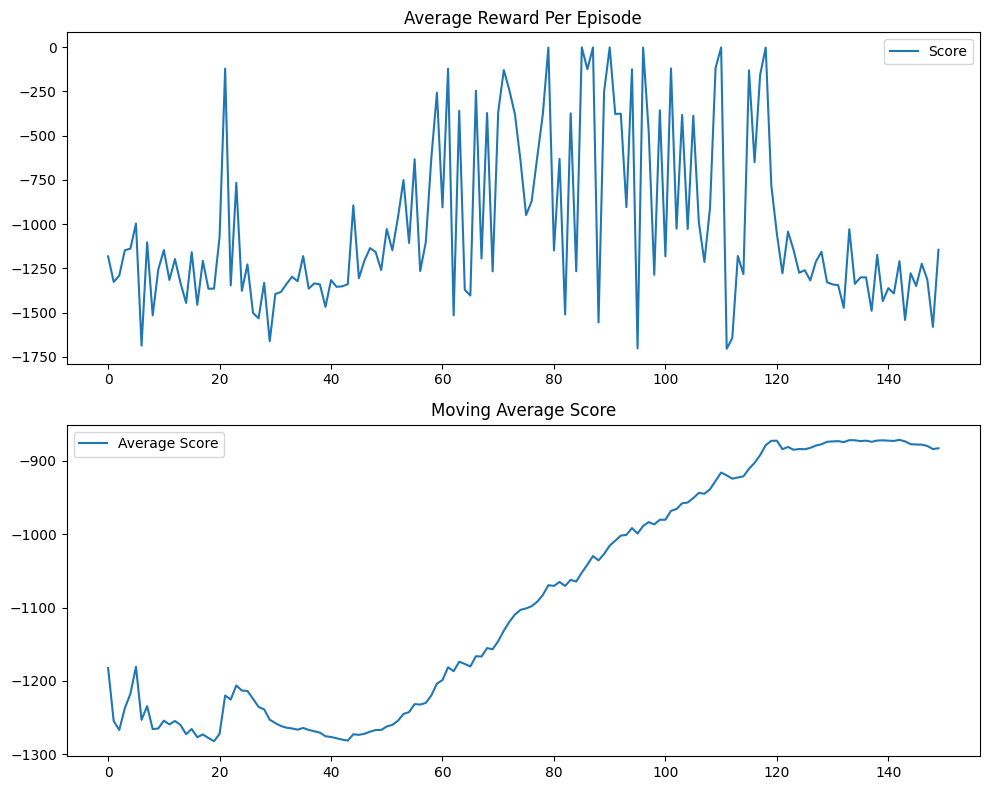

In [17]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(x=episode_number, y=base_scores, label="Score")
plt.title('Average Reward Per Episode')

plt.subplot(2, 1, 2)
sns.lineplot(x=episode_number, y=base_average, label="Average Score")
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

## Tune Model
Variables to Tune
1. Gamma # Discount Factor
2. Epsilon 
3. Epsilon Decay
4. Normalize Rewards vs Not
5. NActions
6. Optimiser (Learning Rate) 




In [65]:
## Variables

Gamma = [1, 0.99, 0.98, 0.97]
MemorySize = [10000, 20000, 30000, 40000]
Epsilon_Decay = [0.995, 0.99, 0.98]
Epsilon = [0.1, 0.2, 0.3, 0.4]
Normalize = [True, False]
Update_Target = [1, 2, 3, 4]
Learning_Rate = [0.0001, 0.0005, 0.001, 0.0015] 
Dense_no = [32, 64, 128]

NActions = [40, 50, 60, 70]

## Gamma (Discount Factor)



In [19]:
Gamma_scores = []
Gamma_average = []
for i in Gamma:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = i)
    scores, average = RunEpisodes(dqn, EPISODES)
    Gamma_scores.append(scores)
    Gamma_average.append(average)

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Inpu

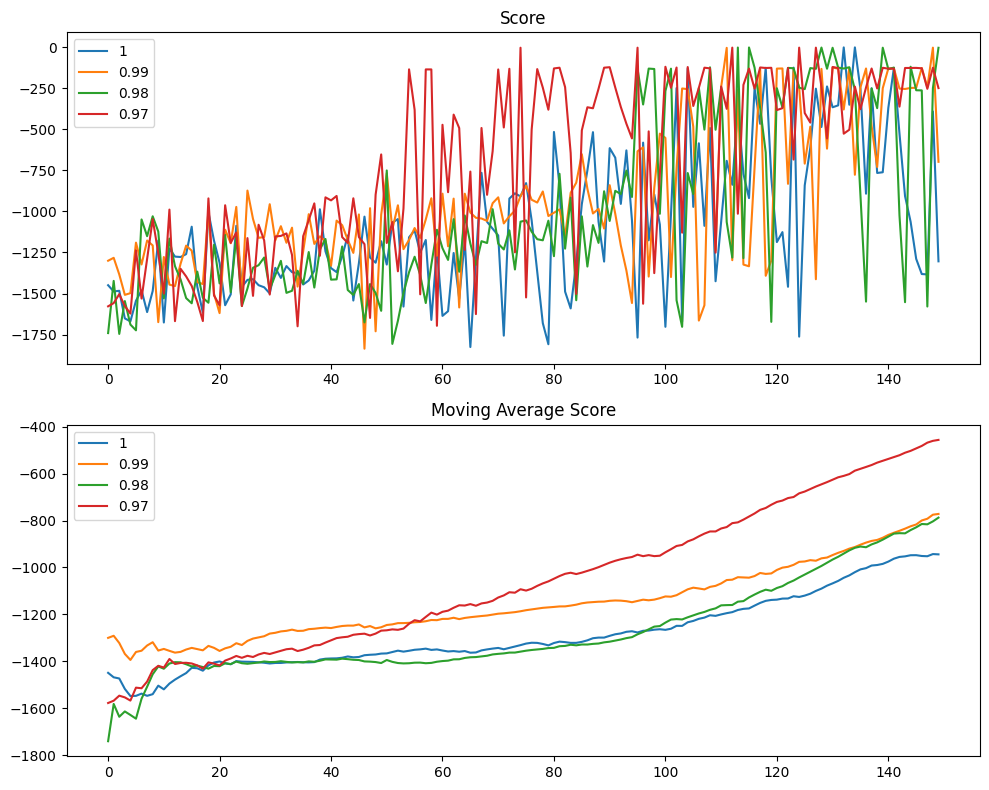

In [20]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Gamma)):
    sns.lineplot(x=episode_number, y=Gamma_scores[i], label=Gamma[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Gamma)):
    sns.lineplot(x=episode_number, y=Gamma_average[i], label=Gamma[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

## Reward Normalization

Need to adjust Train Function

In [35]:
Normalization_Score = []
Normalization_average = []
for i in Normalize:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.97)
    scores, average = RunEpisodes(dqn, EPISODES, Normalize=i)
    Normalization_Score.append(scores)
    Normalization_average.append(average)

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 


 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 

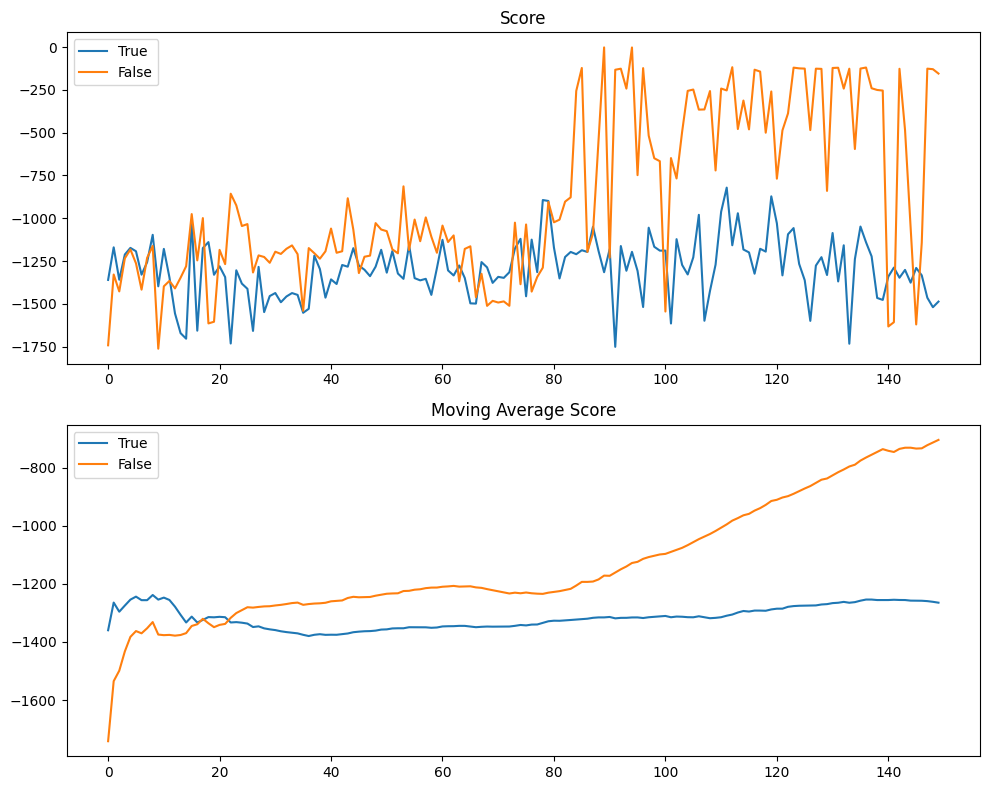

In [37]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Normalize)):
    sns.lineplot(x=episode_number, y=Normalization_Score[i], label=Normalize[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Normalize)):
    sns.lineplot(x=episode_number, y=Normalization_average[i], label=Normalize[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

## Epsilon Decay

In [50]:
Epsilon_Decay_Scores = []
Epsilon_Decay_Average = []
for i in Epsilon_Decay:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.97, Epsilon_Decay = i)
    scores, average = RunEpisodes(dqn, EPISODES)
    Epsilon_Decay_Scores.append(scores)
    Epsilon_Decay_Average.append(average)

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0, Score : -1232.1512651132252, Moving Average : -1232.1512651132252, Epsilon : 0.0995
Episode 1, Score : -1074.233406342809, Moving Average : -1153.1

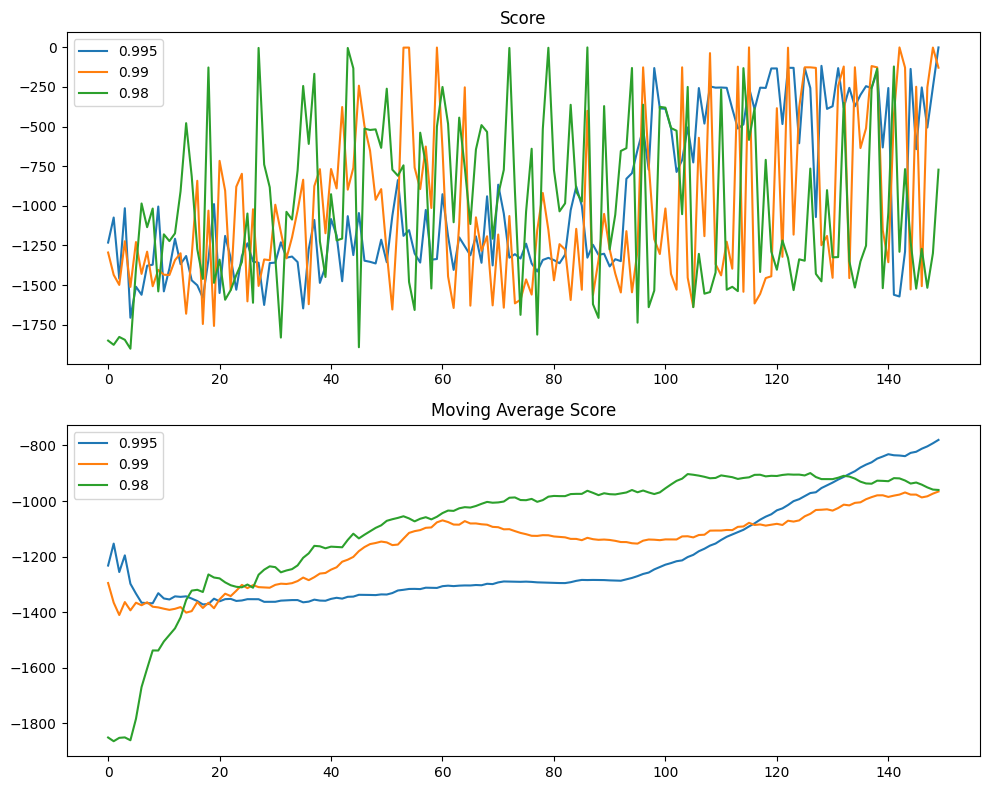

In [51]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Epsilon_Decay)):
    sns.lineplot(x=episode_number, y=Epsilon_Decay_Scores[i], label=Epsilon_Decay[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Epsilon_Decay)):
    sns.lineplot(x=episode_number, y=Epsilon_Decay_Average[i], label=Epsilon_Decay[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

## NActions


In [60]:
NActions_Score = []
NActions_Average = []
for i in NActions:
    dqn = DQN(InputShape = 3, NActions = i, Gamma = 0.97, Epsilon_Decay=0.995)
    scores, average = RunEpisodes(dqn, EPISODES)
    NActions_Score.append(scores)
    NActions_Average.append(average)

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 


Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________

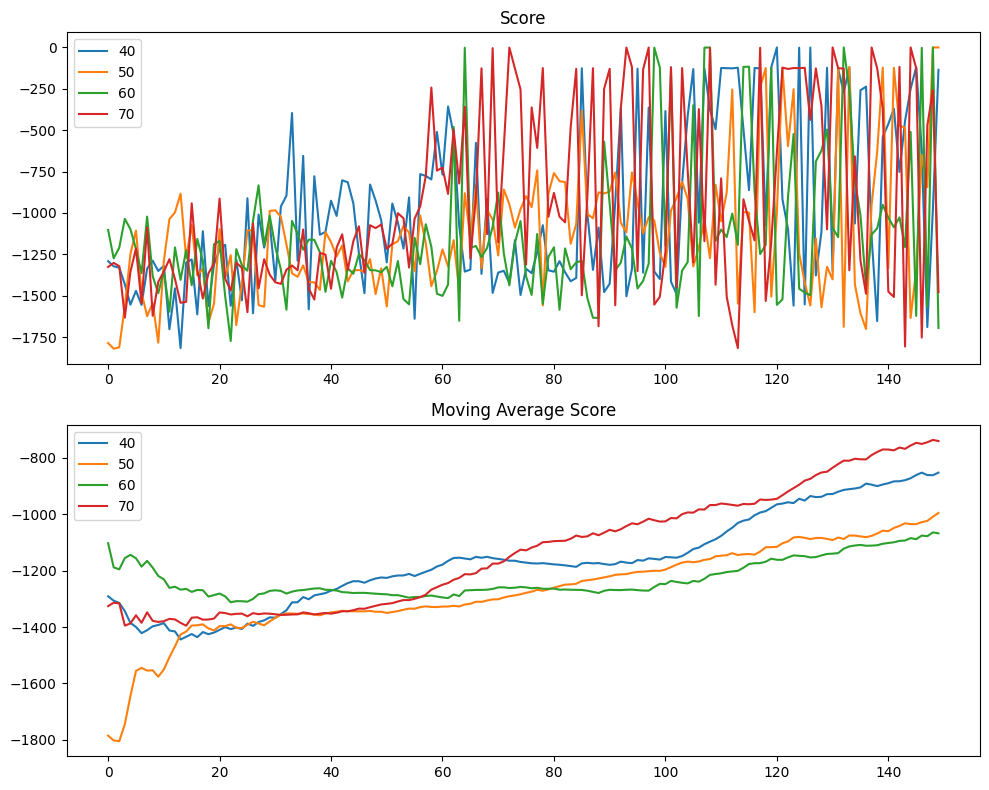

In [62]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(NActions)):
    sns.lineplot(x=episode_number, y=NActions_Score[i], label=NActions[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(NActions)):
    sns.lineplot(x=episode_number, y=NActions_Average[i], label=NActions[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

## Learning Rate

In [66]:
Learning_Rate_Score = []
Learning_Rate_Average = []
for i in Learning_Rate:
    dqn = DQN(InputShape = 3, NActions = 70, Gamma = 0.97, Epsilon_Decay=0.995, learning_rate= i)
    scores, average = RunEpisodes(dqn, EPISODES)
    Learning_Rate_Score.append(scores)
    Learning_Rate_Average.append(average)
    



Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 


 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 70)                4550      
                                                                 
Total params: 8966 (35.02 KB)
Trainable params: 8966 (35.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)   

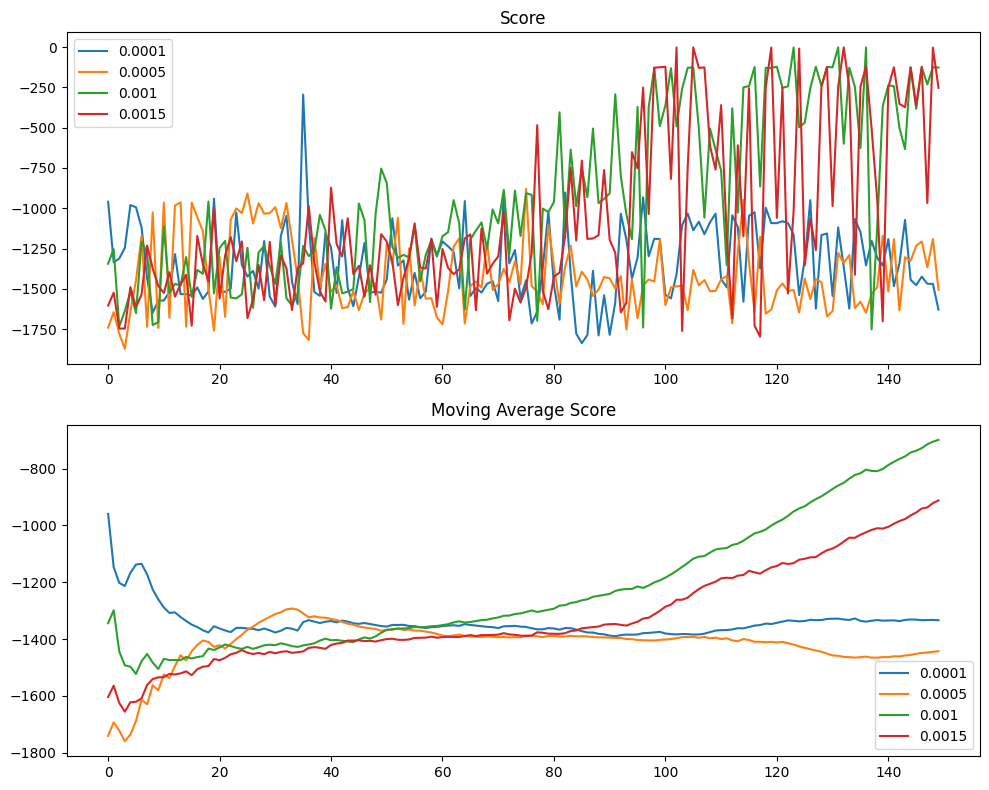

In [67]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Learning_Rate)):
    sns.lineplot(x=episode_number, y=Learning_Rate_Score[i], label=Learning_Rate[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Learning_Rate)):
    sns.lineplot(x=episode_number, y=Learning_Rate_Average[i], label=Learning_Rate[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()